Original image shape: (300, 451)


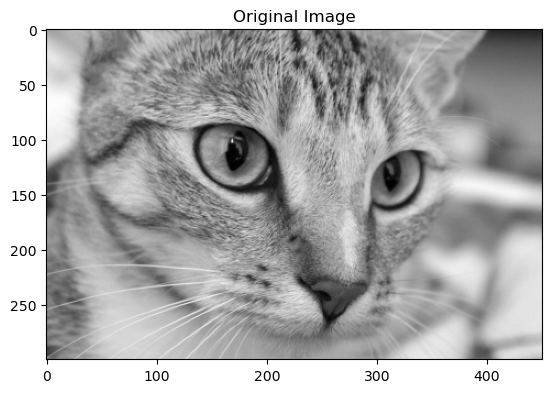


**Working with conv layer 1**
Applying Filter 1
Applying Filter 2
**End of conv layer 1**


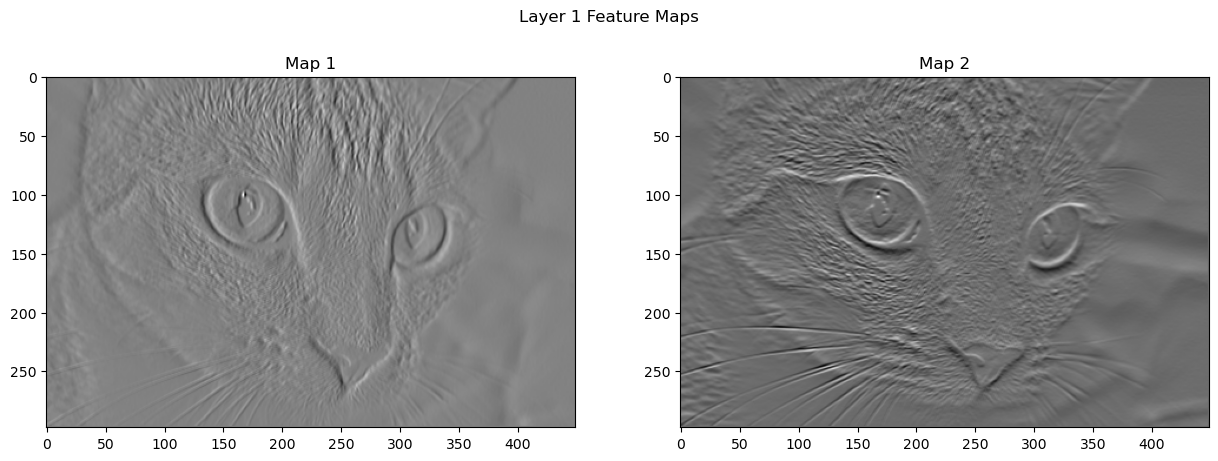

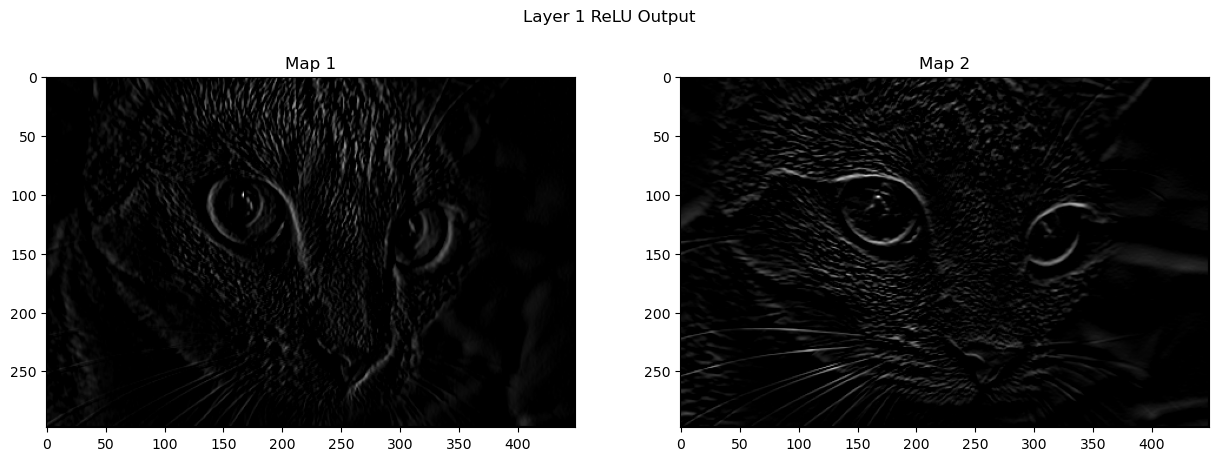

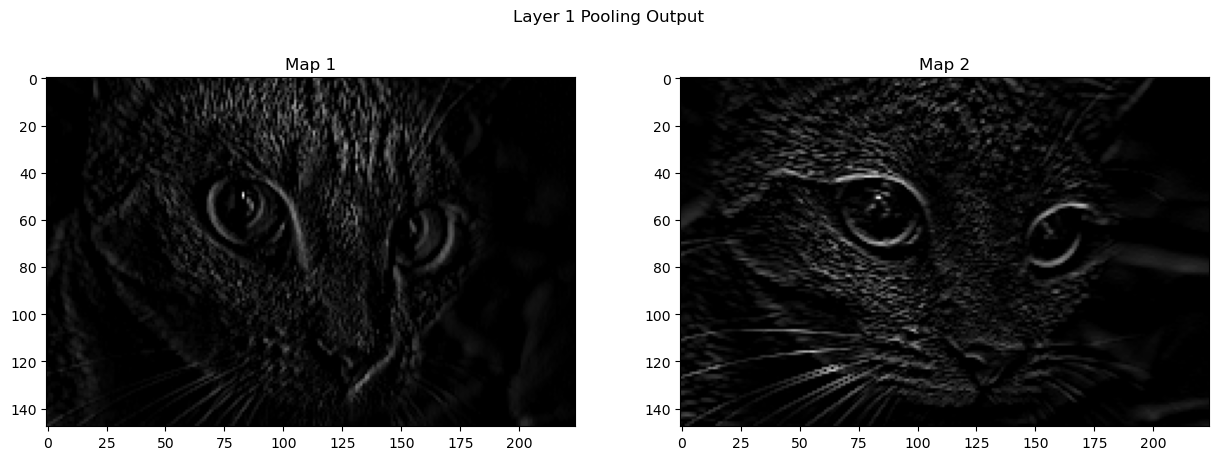


**Working with conv layer 2**
Applying Filter 1
Applying Filter 2
Applying Filter 3
**End of conv layer 2**



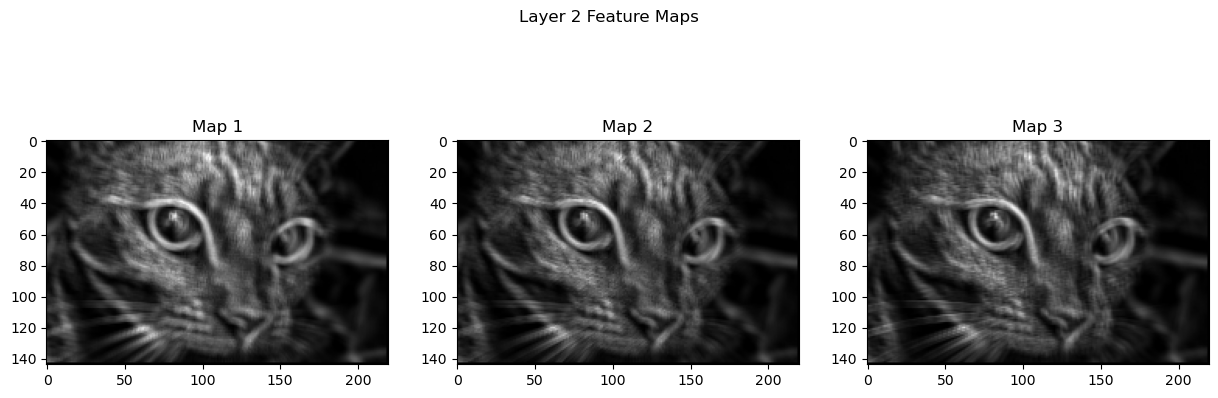

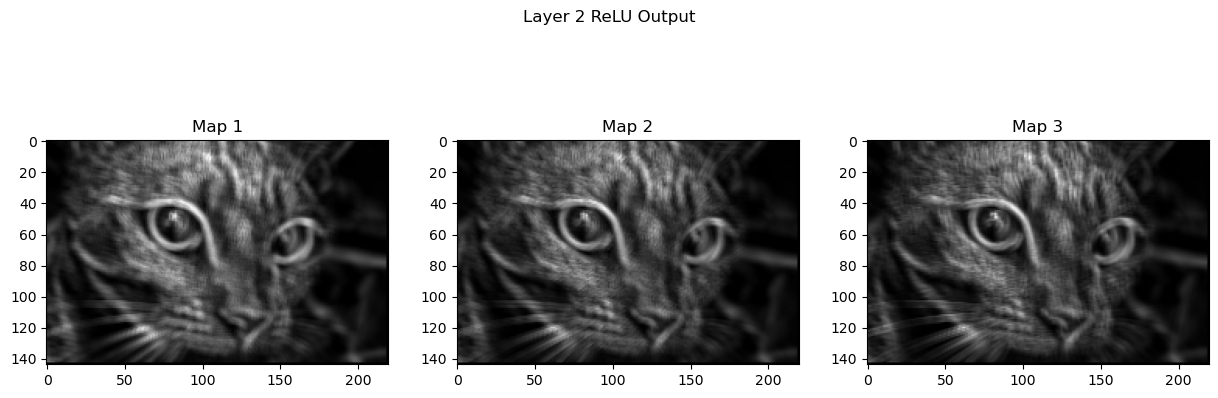

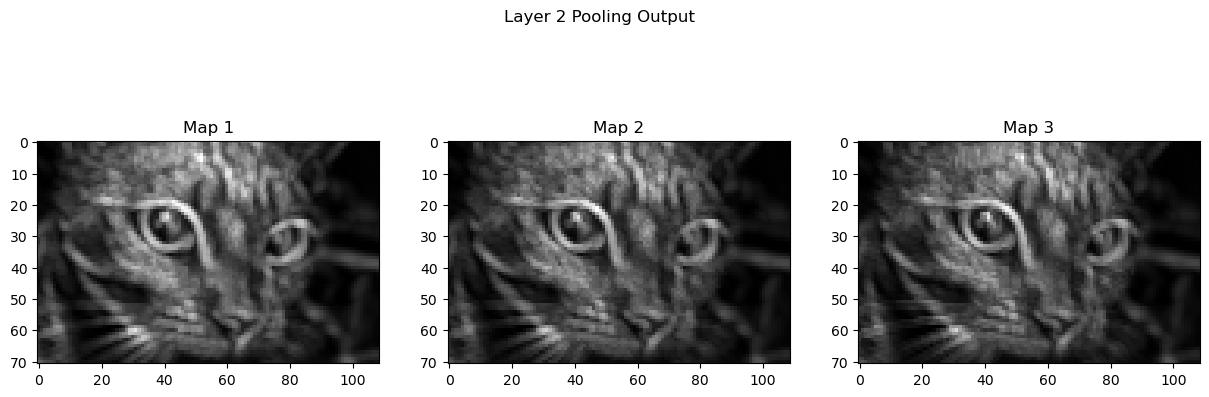


**Working with conv layer 3**
Applying Filter 1
**End of conv layer 3**



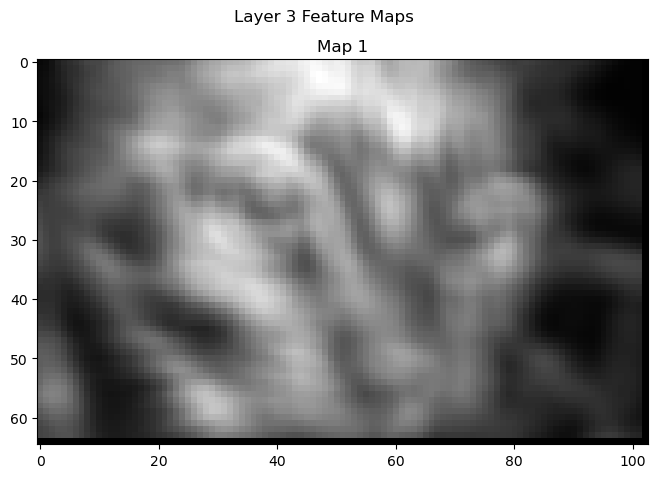

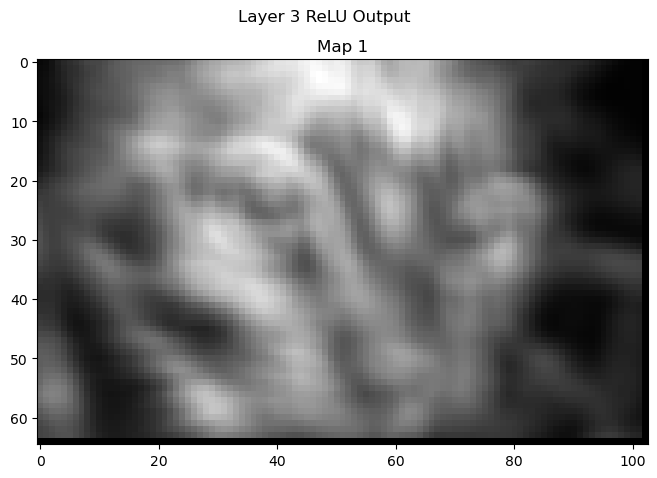

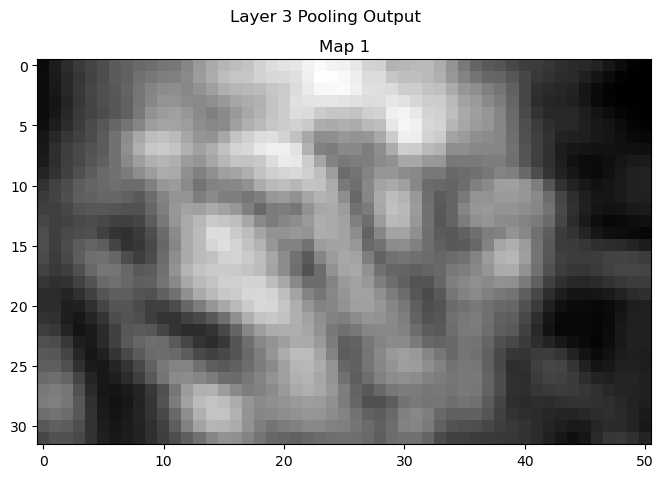

In [13]:
import numpy as np
import skimage.data
import skimage.color
import sys
import matplotlib.pyplot as plt

def conv(img, conv_filter):
    """
    Performs the convolution operation between an image and a filter bank.
    
    Returns:
        numpy.array: The feature maps resulting from the convolution.
    """
    # Check for valid filter dimensions and channels
    if len(img.shape) > 2 and len(conv_filter.shape) > 3:
        if img.shape[-1] != conv_filter.shape[-1]:
            print("Error: Number of channels in both image and filter must match.")
            sys.exit()
    if conv_filter.shape[1] != conv_filter.shape[2]:
        print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')
        sys.exit()
    if conv_filter.shape[1] % 2 == 0:
        print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')
        sys.exit()

    # An empty feature map to hold the output of convolving the filter(s) with the image.
    feature_maps = np.zeros((img.shape[0] - conv_filter.shape[1] + 1,
                             img.shape[1] - conv_filter.shape[1] + 1,
                             conv_filter.shape[0]))

    # Convolving the image by the filter(s).
    for filter_num in range(conv_filter.shape[0]):
        print(f"Applying Filter {filter_num + 1}")
        curr_filter = conv_filter[filter_num, :] # getting a filter from the bank.
        
        # Checking if there are mutliple channels for the single filter.
        # If so, then each channel will convolve the image.
        # The result of all convolutions are summed to return a single feature map.
        if len(curr_filter.shape) > 2:
            conv_map = conv_single_channel(img[:, :, 0], curr_filter[:, :, 0]) # Array holding the sum of all feature maps.
            for ch_num in range(1, curr_filter.shape[-1]): # Convolving each channel with the image and summing the results.
                conv_map = conv_map + conv_single_channel(img[:, :, ch_num], curr_filter[:, :, ch_num])
        else: # There is just a single channel in the filter.
            conv_map = conv_single_channel(img, curr_filter)
        
        feature_maps[:, :, filter_num] = conv_map # Holding feature map with the current filter.
    
    return feature_maps # Returning all feature maps.

def conv_single_channel(img, conv_filter):
    """
    Performs convolution on a single-channel image.
    
    Args:
        img (numpy.array): The single-channel image.
        conv_filter (numpy.array): The 2D convolution filter.
        
    Returns:
        numpy.array: The resulting feature map.
    """
    filter_size = conv_filter.shape[0]
    result = np.zeros(img.shape)
    
    # Looping through the image to apply the convolution operation.
    for r in np.uint16(np.arange(filter_size/2, img.shape[0] - filter_size/2)):
        for c in np.uint16(np.arange(filter_size/2, img.shape[1] - filter_size/2)):
            # Getting the current region to get multiplied with the filter.
            curr_region = img[r - int(filter_size/2) : r + int(filter_size/2) + 1,
                              c - int(filter_size/2) : c + int(filter_size/2) + 1]
            # Element-wise multiplication between the current region and the filter.
            curr_result = curr_region * conv_filter
            conv_sum = np.sum(curr_result) # Summing the result of multiplication.
            result[r, c] = conv_sum # Saving the summation in the convolution layer feature map.

    # Clipping the outliers of the result matrix.
    final_result = result[np.uint16(filter_size/2) : result.shape[0] - np.uint16(filter_size/2),
                          np.uint16(filter_size/2) : result.shape[1] - np.uint16(filter_size/2)]
    return final_result

def relu(feature_map):
    """
    Applies the ReLU activation function to a feature map.
    Returns:
        numpy.array: The output feature map after applying ReLU.
    """
    relu_out = np.zeros(feature_map.shape)
    for map_num in range(feature_map.shape[-1]):
        for r in np.arange(0, feature_map.shape[0]):
            for c in np.arange(0, feature_map.shape[1]):
                relu_out[r, c, map_num] = np.max([feature_map[r, c, map_num], 0])
    return relu_out

def pooling(feature_map, size=2, stride=2):
    """
    Performs max pooling on a feature map.
    
    Returns:
        numpy.array: The pooled feature map.
    """
    pool_out = np.zeros((np.uint16((feature_map.shape[0] - size + 1) / stride),
                         np.uint16((feature_map.shape[1] - size + 1) / stride),
                         feature_map.shape[-1]))
    r2 = 0
    for r in np.arange(0, feature_map.shape[0] - size, stride):
        c2 = 0
        for c in np.arange(0, feature_map.shape[1] - size, stride):
            pool_out[r2, c2, :] = np.max(feature_map[r : r + size, c : c + size, :], axis=(0, 1))
            c2 += 1
        r2 += 1
    return pool_out

if __name__ == "__main__":
    # Reading the image and converting to grayscale
    img = skimage.data.chelsea()
    img = skimage.color.rgb2gray(img)
    print("Original image shape:", img.shape)
    
    # Plot original image
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.show()

    # ------------------ First Convolutional Layer ------------------
    print("\n**Working with conv layer 1**")
    
    # Define and initialize filters for the first layer
    l1_filter = np.zeros((2, 3, 3))
    l1_filter[0, :, :] = np.array([[-1, 0, 1],
                                   [-1, 0, 1],
                                   [-1, 0, 1]])
    l1_filter[1, :, :] = np.array([[1, 1, 1],
                                   [0, 0, 0],
                                   [-1, -1, -1]])
    
    # Perform convolution, ReLU, and Pooling
    l1_feature_map = conv(img, l1_filter)
    l1_feature_map_relu = relu(l1_feature_map)
    l1_feature_map_relu_pool = pooling(l1_feature_map_relu, 2, 2)
    print("**End of conv layer 1**")
    
    # Plot outputs of Layer 1
    num_maps_l1 = l1_feature_map.shape[-1]
    fig, axs = plt.subplots(1, num_maps_l1, figsize=(15, 5))
    fig.suptitle('Layer 1 Feature Maps')
    if num_maps_l1 > 1:
        for i in range(num_maps_l1):
            axs[i].imshow(l1_feature_map[:, :, i], cmap='gray')
            axs[i].set_title(f'Map {i+1}')
    else:
        axs.imshow(l1_feature_map[:, :, 0], cmap='gray')
        axs.set_title('Map 1')
    plt.show()

    num_maps_l1_relu = l1_feature_map_relu.shape[-1]
    fig, axs = plt.subplots(1, num_maps_l1_relu, figsize=(15, 5))
    fig.suptitle('Layer 1 ReLU Output')
    if num_maps_l1_relu > 1:
        for i in range(num_maps_l1_relu):
            axs[i].imshow(l1_feature_map_relu[:, :, i], cmap='gray')
            axs[i].set_title(f'Map {i+1}')
    else:
        axs.imshow(l1_feature_map_relu[:, :, 0], cmap='gray')
        axs.set_title('Map 1')
    plt.show()

    num_maps_l1_pool = l1_feature_map_relu_pool.shape[-1]
    fig, axs = plt.subplots(1, num_maps_l1_pool, figsize=(15, 5))
    fig.suptitle('Layer 1 Pooling Output')
    if num_maps_l1_pool > 1:
        for i in range(num_maps_l1_pool):
            axs[i].imshow(l1_feature_map_relu_pool[:, :, i], cmap='gray')
            axs[i].set_title(f'Map {i+1}')
    else:
        axs.imshow(l1_feature_map_relu_pool[:, :, 0], cmap='gray')
        axs.set_title('Map 1')
    plt.show()

    # ------------------ Second Convolutional Layer ------------------
    print("\n**Working with conv layer 2**")
    
    # Define and initialize filters for the second layer
    l2_filter = np.random.rand(3, 5, 5, l1_feature_map_relu_pool.shape[-1])
    
    # Perform convolution, ReLU, and Pooling
    l2_feature_map = conv(l1_feature_map_relu_pool, l2_filter)
    l2_feature_map_relu = relu(l2_feature_map)
    l2_feature_map_relu_pool = pooling(l2_feature_map_relu, 2, 2)
    print("**End of conv layer 2**\n")
    
    # Plot outputs of Layer 2
    num_maps_l2 = l2_feature_map.shape[-1]
    fig, axs = plt.subplots(1, num_maps_l2, figsize=(15, 5))
    fig.suptitle('Layer 2 Feature Maps')
    if num_maps_l2 > 1:
        for i in range(num_maps_l2):
            axs[i].imshow(l2_feature_map[:, :, i], cmap='gray')
            axs[i].set_title(f'Map {i+1}')
    else:
        axs.imshow(l2_feature_map[:, :, 0], cmap='gray')
        axs.set_title('Map 1')
    plt.show()

    num_maps_l2_relu = l2_feature_map_relu.shape[-1]
    fig, axs = plt.subplots(1, num_maps_l2_relu, figsize=(15, 5))
    fig.suptitle('Layer 2 ReLU Output')
    if num_maps_l2_relu > 1:
        for i in range(num_maps_l2_relu):
            axs[i].imshow(l2_feature_map_relu[:, :, i], cmap='gray')
            axs[i].set_title(f'Map {i+1}')
    else:
        axs.imshow(l2_feature_map_relu[:, :, 0], cmap='gray')
        axs.set_title('Map 1')
    plt.show()

    num_maps_l2_pool = l2_feature_map_relu_pool.shape[-1]
    fig, axs = plt.subplots(1, num_maps_l2_pool, figsize=(15, 5))
    fig.suptitle('Layer 2 Pooling Output')
    if num_maps_l2_pool > 1:
        for i in range(num_maps_l2_pool):
            axs[i].imshow(l2_feature_map_relu_pool[:, :, i], cmap='gray')
            axs[i].set_title(f'Map {i+1}')
    else:
        axs.imshow(l2_feature_map_relu_pool[:, :, 0], cmap='gray')
        axs.set_title('Map 1')
    plt.show()

    # ------------------ Third Convolutional Layer ------------------
    print("\n**Working with conv layer 3**")
    
    # Define and initialize filters for the third layer
    l3_filter = np.random.rand(1, 7, 7, l2_feature_map_relu_pool.shape[-1])
    
    # Perform convolution, ReLU, and Pooling
    l3_feature_map = conv(l2_feature_map_relu_pool, l3_filter)
    l3_feature_map_relu = relu(l3_feature_map)
    l3_feature_map_relu_pool = pooling(l3_feature_map_relu, 2, 2)
    print("**End of conv layer 3**\n")

    # Plot outputs of Layer 3
    num_maps_l3 = l3_feature_map.shape[-1]
    fig, axs = plt.subplots(1, num_maps_l3, figsize=(15, 5))
    fig.suptitle('Layer 3 Feature Maps')
    if num_maps_l3 > 1:
        for i in range(num_maps_l3):
            axs[i].imshow(l3_feature_map[:, :, i], cmap='gray')
            axs[i].set_title(f'Map {i+1}')
    else:
        axs.imshow(l3_feature_map[:, :, 0], cmap='gray')
        axs.set_title('Map 1')
    plt.show()

    num_maps_l3_relu = l3_feature_map_relu.shape[-1]
    fig, axs = plt.subplots(1, num_maps_l3_relu, figsize=(15, 5))
    fig.suptitle('Layer 3 ReLU Output')
    if num_maps_l3_relu > 1:
        for i in range(num_maps_l3_relu):
            axs[i].imshow(l3_feature_map_relu[:, :, i], cmap='gray')
            axs[i].set_title(f'Map {i+1}')
    else:
        axs.imshow(l3_feature_map_relu[:, :, 0], cmap='gray')
        axs.set_title('Map 1')
    plt.show()

    num_maps_l3_pool = l3_feature_map_relu_pool.shape[-1]
    fig, axs = plt.subplots(1, num_maps_l3_pool, figsize=(15, 5))
    fig.suptitle('Layer 3 Pooling Output')
    if num_maps_l3_pool > 1:
        for i in range(num_maps_l3_pool):
            axs[i].imshow(l3_feature_map_relu_pool[:, :, i], cmap='gray')
            axs[i].set_title(f'Map {i+1}')
    else:
        axs.imshow(l3_feature_map_relu_pool[:, :, 0], cmap='gray')
        axs.set_title('Map 1')
    plt.show()